In [1]:
import sys 
sys.path.append("..")
import cv2 
from get_ros2topic import ZED
import numpy as np 
import rclpy
import matplotlib.pyplot as plt
from sensor_msgs.msg import PointCloud2

print("Done.")


Done.


In [2]:
import sensor_msgs.msg as sensor_msgs
import pcl
sys.path.append("../../../")
from ros2_numpy import ros2_numpy


def ros_to_pcl(ros_cloud):
    """ 
        Converts a ROS PointCloud2 message to a pcl PointXYZRGB
        Args:
            ros_cloud (PointCloud2): ROS PointCloud2 message
        Returns:
            pcl.PointCloud_PointXYZRGB: PCL XYZRGB point cloud
    """
    points_list = []

    for data in ros2_numpy.point_cloud2.pointcloud2_to_array(ros_cloud):
        points_list.append([data[0], data[1], data[2], data[3]])
    pcl_data = pcl.PointCloud_PointXYZRGB()
    pcl_data.from_list(points_list)
    return pcl_data

def ros_to_numpy(ros_cloud):
    pc = ros2_numpy.point_cloud2.pointcloud2_to_array(ros_cloud)
    pc = pc[~np.isnan(pc['x']) & ~np.isnan(pc['y']) & ~np.isnan(pc['z'])]
    height = ros_cloud.height
    width = ros_cloud.width
    points = np.zeros((height, width, 3), dtype=np.float32)
    points[:, :, 0] = pc['x'].reshape(height, width)
    points[:, :, 1] = pc['y'].reshape(height, width)
    points[:, :, 2] = pc['z'].reshape(height, width)
    return points 

### Get Pointcloud data 

In [3]:
rclpy.init(args=sys.argv)
node = rclpy.create_node('ZED')

mode     = "pointcloud"
camera   = ZED(mode=mode)

[ERROR] CHECK ZED


In [4]:
from sensor_msgs.msg import PointCloud2, Image
from message_filters import TimeSynchronizer, Subscriber

def callback(node, depth_msg, rgb_msg):
    tick = tick+1
    color_image = rgb_msg
    pointcloud = depth_msg

rgb_image_sub = Subscriber(node, Image, '/zed2i/zed_node/rgb_raw/image_raw_color')
pointcloud_sub = Subscriber(node, PointCloud2, '/zed2i/zed_node/point_cloud/cloud_registered')
ts = TimeSynchronizer([pointcloud_sub, rgb_image_sub], 10)

ts.registerCallback(callback)


0

In [6]:
pcl_data = ros_to_pcl(camera.point_cloud)
print("Type: {}".format(type(pcl_data)))
numpy_data = ros_to_numpy(camera.point_cloud)
print("Numpy Points Shape: {}".format(numpy_data.shape))
print("Type: {}".format(type(numpy_data)))


AttributeError: 'NoneType' object has no attribute 'fields'

In [1]:
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import PointCloud2

import numpy as np

class PointCloudSubscriber(Node):
    def __init__(self):
        super().__init__('point_cloud_subscriber')
        self.subscription = self.create_subscription(
            PointCloud2,
            '/zed2i/zed_node/point_cloud/cloud_registered',
            self.point_cloud_callback,
            10)

    def point_cloud_callback(self, msg):
        # Convert the point cloud data to a numpy array
        self.get_logger().info('I heard: "%d"' % msg.num) # CHANGE
        pc_array = np.array(msg.data, dtype=np.float32).reshape(-1, msg.point_step // 4)

        # Save the numpy array to a file
        np.save('point_cloud.npy', pc_array)

        # Print some information about the point cloud
        self.get_logger().info(f'Received point cloud with {pc_array.shape[0]} points')

def main(args=None):
    rclpy.init(args=args)
    node = PointCloudSubscriber()
    rclpy.spin(node)
    node.destroy_node()
    rclpy.shutdown()

if __name__ == '__main__':
    main()


KeyboardInterrupt: 

### Plot Pointcloud data

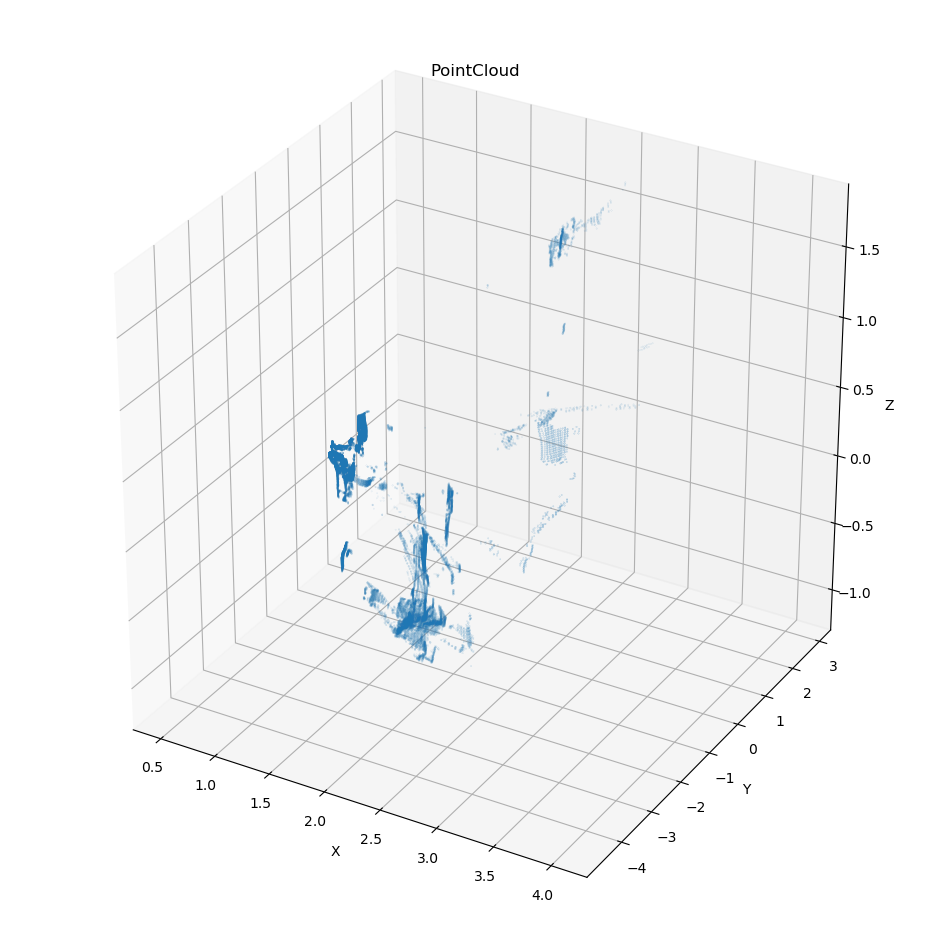

In [ ]:
fig=plt.figure(figsize=(12,12))
ax = fig.gca(projection="3d")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("PointCloud")
#ax.view_init(30,60)
ax.scatter(numpy_data[:,:,0], numpy_data[:,:,1], numpy_data[:,:,2], s=0.01)

In [ ]:
import open3d 
pcl_data = ros_to_pcl(camera.point_cloud)
pcl_array = np.asarray(pcl_data)
print("Type: {}".format(type(pcl_array)))

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Type: <class 'numpy.ndarray'>


: 

In [1]:
import sys
import os

import rclpy 
from rclpy.node import Node
import sensor_msgs.msg as sensor_msgs


import numpy as np
import open3d as o3d

class PCDListener(Node):

    def __init__(self):
        super().__init__('pcd_subsriber_node')

        ## This is for visualization of the received point cloud.
        self.vis = o3d.visualization.Visualizer()
        self.vis.create_window()
        self.o3d_pcd = o3d.geometry.PointCloud()


        # Set up a subscription to the 'pcd' topic with a callback to the 
        # function `listener_callback`
        self.pcd_subscriber = self.create_subscription(
            sensor_msgs.PointCloud2,    # Msg type
            '/zed2i/zed_node/point_cloud/cloud_registered',                      # topic
            self.listener_callback,      # Function to call
            10                          # QoS
        )

                
    def listener_callback(self, msg):
        # Here we convert the 'msg', which is of the type PointCloud2.
        # I ported the function read_points2 from 
        # the ROS1 package. 
        # https://github.com/ros/common_msgs/blob/noetic-devel/sensor_msgs/src/sensor_msgs/point_cloud2.py

        pcd_as_numpy_array = np.array(list(read_points(msg)))
        

        # The rest here is for visualization.
        self.vis.remove_geometry(self.o3d_pcd)
        self.o3d_pcd = o3d.geometry.PointCloud(
                            o3d.utility.Vector3dVector(pcd_as_numpy_array))
        self.vis.add_geometry(self.o3d_pcd)
        self.vis.poll_events()
        self.vis.update_renderer()

        


## The code below is "ported" from 
# https://github.com/ros/common_msgs/tree/noetic-devel/sensor_msgs/src/sensor_msgs
# I'll make an official port and PR to this repo later: 
# https://github.com/ros2/common_interfaces
import sys
from collections import namedtuple
import ctypes
import math
import struct
from sensor_msgs.msg import PointCloud2, PointField

_DATATYPES = {}
_DATATYPES[PointField.INT8]    = ('b', 1)
_DATATYPES[PointField.UINT8]   = ('B', 1)
_DATATYPES[PointField.INT16]   = ('h', 2)
_DATATYPES[PointField.UINT16]  = ('H', 2)
_DATATYPES[PointField.INT32]   = ('i', 4)
_DATATYPES[PointField.UINT32]  = ('I', 4)
_DATATYPES[PointField.FLOAT32] = ('f', 4)
_DATATYPES[PointField.FLOAT64] = ('d', 8)

def read_points(cloud, field_names=None, skip_nans=False, uvs=[]):
    """
    Read points from a L{sensor_msgs.PointCloud2} message.

    @param cloud: The point cloud to read from.
    @type  cloud: L{sensor_msgs.PointCloud2}
    @param field_names: The names of fields to read. If None, read all fields. [default: None]
    @type  field_names: iterable
    @param skip_nans: If True, then don't return any point with a NaN value.
    @type  skip_nans: bool [default: False]
    @param uvs: If specified, then only return the points at the given coordinates. [default: empty list]
    @type  uvs: iterable
    @return: Generator which yields a list of values for each point.
    @rtype:  generator
    """
    assert isinstance(cloud, PointCloud2), 'cloud is not a sensor_msgs.msg.PointCloud2'
    fmt = _get_struct_fmt(cloud.is_bigendian, cloud.fields, field_names)
    width, height, point_step, row_step, data, isnan = cloud.width, cloud.height, cloud.point_step, cloud.row_step, cloud.data, math.isnan
    unpack_from = struct.Struct(fmt).unpack_from

    if skip_nans:
        if uvs:
            for u, v in uvs:
                p = unpack_from(data, (row_step * v) + (point_step * u))
                has_nan = False
                for pv in p:
                    if isnan(pv):
                        has_nan = True
                        break
                if not has_nan:
                    yield p
        else:
            for v in range(height):
                offset = row_step * v
                for u in range(width):
                    p = unpack_from(data, offset)
                    has_nan = False
                    for pv in p:
                        if isnan(pv):
                            has_nan = True
                            break
                    if not has_nan:
                        yield p
                    offset += point_step
    else:
        if uvs:
            for u, v in uvs:
                yield unpack_from(data, (row_step * v) + (point_step * u))
        else:
            for v in range(height):
                offset = row_step * v
                for u in range(width):
                    yield unpack_from(data, offset)
                    offset += point_step

def _get_struct_fmt(is_bigendian, fields, field_names=None):
    fmt = '>' if is_bigendian else '<'

    offset = 0
    for field in (f for f in sorted(fields, key=lambda f: f.offset) if field_names is None or f.name in field_names):
        if offset < field.offset:
            fmt += 'x' * (field.offset - offset)
            offset = field.offset
        if field.datatype not in _DATATYPES:
            print('Skipping unknown PointField datatype [%d]' % field.datatype, file=sys.stderr)
        else:
            datatype_fmt, datatype_length = _DATATYPES[field.datatype]
            fmt    += field.count * datatype_fmt
            offset += field.count * datatype_length

    return fmt



def main(args=None):
    # Boilerplate code.
    rclpy.init(args=args)
    pcd_listener = PCDListener()
    rclpy.spin(pcd_listener)
    
    # Destroy the node explicitly
    # (optional - otherwise it will be done automatically
    # when the garbage collector destroys the node object)
    pcd_listener.destroy_node()
    rclpy.shutdown()

if __name__ == '__main__':
    main()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


: 

: 

In [ ]:
import point_cloud2 as rnp


In [ ]:
from sensor_msgs.msg import PointCloud2
from sensor_msgs import point_cloud2

def callback_pointcloud(data):
    gen = point_cloud2.read_points(data)
    print(type(gen))
    for p in gen:
      print(p)  # type depends on your data type, first three entries are probably x,y,z

ImportError: cannot import name '_point_cloud2' from 'sensor_msgs' (/opt/ros/foxy/lib/python3.8/site-packages/sensor_msgs/__init__.py)

In [ ]:
#!/usr/bin/env python3
# coding: utf-8
import rclpy
from rclpy.node import Node
from rclpy.qos import QoSProfile
# from sensor_msgs.msg import PointCloud2
import sensor_msgs.msg as sensor_msgs

import pcl


def callback(input_ros_msg):
    # cloud = ros_to_pcl(input_ros_msg)

    # # 실행 코드 부분 
    # print(cloud)

    # cloud_new = pcl_to_ros(cloud) # PCL을 ROS 메시지로 변경     
    # pub.publish(cloud_new)
    print(1)

if __name__ == "__main__":
    # rclpy.init(args=sys.argv)
    node = rclpy.create_node('ZED')
    qpos_profile = QoSProfile(depth=10)

    pcd_subscriber = Node.create_subscription(
        sensor_msgs.PointCloud2,    # Msg type
        '/zed2i/zed_node/point_cloud/cloud_registered', # topic
        callback(),     # Function to call
        10                          # QoS
    )
    sub = node.create_subscription(PointCloud2, '/zed2i/zed_node/point_cloud/cloud_registered', qos_profile=1, callback=callback)
    pub = node.create_publisher(PointCloud2, '/zed2i/zed_node/point_cloud/cloud_registered', qos_profile=1, callback=callback)

    rclpy.spin(sub) # 콜백 실행

    # Destroy the node explicitly
    # (optional - otherwise it will be done automatically
    # when the garbage collector destroys the node object)
    sub.destroy_node() # context가 끝나면 종료되는 것으로 보임
    rclpy.shutdown()

TypeError: create_publisher() got an unexpected keyword argument 'callback'

In [2]:
import cv_bridge 
import cv2 

bridge = cv_bridge.CvBridge()

def save_depth_img(msg_depth):
    img_shape = (640, 360)
    try:
        cv_image_array = bridge.imgmsg_to_cv2(msg_depth, "32FC1")
        cv_image_array = np.array(cv_image_array, dtype = np.dtype('f8'))
        cv_image_array = cv2.resize(cv_image_array, img_shape, interpolation = cv2.INTER_CUBIC)
        cv_image_array = cv2.normalize(cv_image_array, cv_image_array, 0, 255, cv2.NORM_MINMAX)
        print(cv_image_array.shape)
        print(type(cv_image_array))
        print(cv_image_array[0:10,0:10])
        print("Max Depth: {}".format(np.max(cv_image_array))) 
        print("Min Depth: {}".format(np.min(cv_image_array)))
        print("Average Depth: {}".format(np.average(cv_image_array)))
        cv2.imwrite('./data/png/ros.png', cv_image_array*1)
        print('SAVED IMAGE')
        # cv2.imshow("Image from my node", cv_image_array*255)
        # cv2.waitKey(0)

    except cv_bridge.CvBridgeError as e:
        print(e)


/tmp/ipykernel_50027/2062419386.py:62: RuntimeWarning: invalid value encountered in cast
  point_cloud_np.dot(self.tr_np)


[[0.        0.        0.        ... 1.5012833 1.5012906 1.5012941]
 [0.        0.        0.        ... 1.501281  1.5012882 1.5012909]
 [0.        0.        0.        ... 1.501278  1.5012796 1.5012834]
 ...
 [0.        0.        0.        ... 1.5536691 1.5536734 1.5536723]
 [0.        0.        0.        ... 1.553671  1.5536675 1.5536729]
 [0.        0.        0.        ... 1.5536647 1.5536686 1.5536717]]


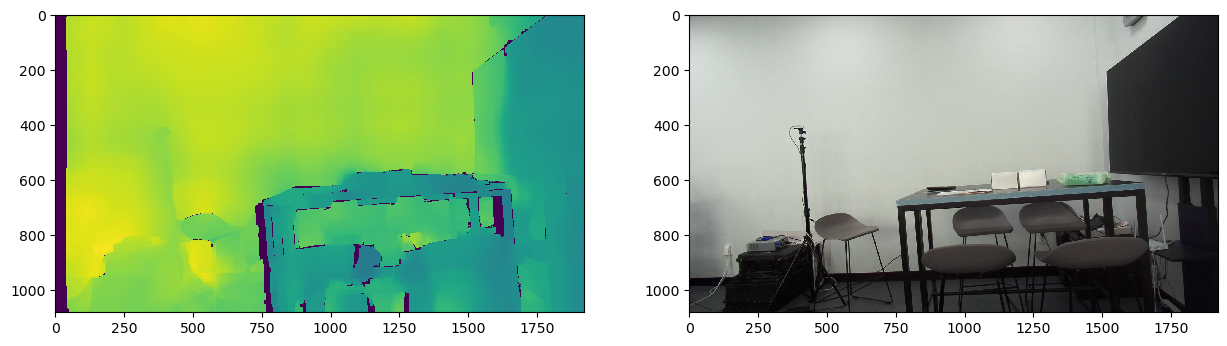

TypeError: no default __reduce__ due to non-trivial __cinit__

In [1]:
import rclpy
from rclpy.node import Node

from sensor_msgs.msg import Image, PointCloud2
from cv_bridge import CvBridge

import pyzed.sl as sl
import numpy as np
import cv2
import matplotlib.pyplot as plt

class CAMNODE(Node):

    def __init__(self):
        super().__init__('cam_node')
        self.color_publisher_ = self.create_publisher(Image, 'zed/color', 10)
        self.depth_publisher_ = self.create_publisher(Image, 'zed/depth', 10)
        self.point_cloud_publisher = self.create_publisher(PointCloud2, 'zed/points',10)
        timer_period = 0.1  # seconds
        self.timer = self.create_timer(timer_period, self.timer_callback)
        self.br = CvBridge()
        self.init_camera()
    
    def init_camera(self):
        # Create a Camera object
        self.zed = sl.Camera()

        # Create a InitParameters object and set configuration parameters
        init_params = sl.InitParameters()
        init_params.camera_resolution = sl.RESOLUTION.HD1080  # Use HD1080 video mode
        init_params.camera_fps = 30  # Set fps at 30

        # Open the camera
        err = self.zed.open(init_params)
        if err != sl.ERROR_CODE.SUCCESS:
            exit(1)
        self.image = sl.Mat()
        self.depth = sl.Mat()
        self.point_cloud = sl.Mat()
        self.runtime_parameters = sl.RuntimeParameters()
        self.image_ocv = np.zeros((1920,1080,4))
        self.depth_ocv = np.zeros((1920,1080))

        mirror_ref = sl.Transform()
        mirror_ref.set_translation(sl.Translation(2.75,4.0,0))
        self.tr_np = mirror_ref.m


    def timer_callback(self):
        if self.zed.grab(self.runtime_parameters) == sl.ERROR_CODE.SUCCESS:
            # A new image is available if grab() returns SUCCESS
            self.zed.retrieve_image(self.image, sl.VIEW.LEFT)
            self.zed.retrieve_measure(self.depth, sl.MEASURE.DEPTH)
            
            self.depth_ocv = self.depth.get_data()
            self.image_ocv = self.image.get_data()
            self.depth_ocv  = np.nan_to_num(self.depth_ocv)/1000

            self.zed.retrieve_measure(self.point_cloud, sl.MEASURE.XYZRGBA)

            point_cloud_np = self.point_cloud.get_data()
            point_cloud_np.dot(self.tr_np)
        
        # print(point_cloud_np[700,700])
        msg = self.br.cv2_to_imgmsg(self.image_ocv)
        self.color_publisher_.publish(msg)

        print(self.depth_ocv)
        plt.figure(figsize=(15,8))
        plt.subplot(1,2,1)
        plt.imshow(self.depth_ocv)
        # plt.show()

        plt.subplot(1,2,2)
        plt.imshow(self.image_ocv)
        plt.show()

        np.save("./data/zed1_depth.npy", self.depth_ocv)
        np.save("./data/zed1_image.npy", self.image_ocv)
        np.save("./data/zed1_pcl.npy", self.point_cloud)

        msg = self.br.cv2_to_imgmsg(self.depth_ocv)
        self.depth_publisher_.publish(msg)

        # self.get_logger().info('Publishing: Image')


def main(args=None):
    rclpy.init(args=args)

    minimal_publisher = CAMNODE()
    rclpy.spin(minimal_publisher)

    # if minimal_publisher.depth_ocv is not None:
    # plt.imshow(minimal_publisher.depth_ocv)
    # plt.show()

    name = "zed_test"
    save_depth_img(msg_depth = minimal_publisher.depth_ocv, name = name) 

    depth_data = minimal_publisher.depth_ocv
    image_data = minimal_publisher.image_ocv
    np.save("./data/zed1_depth.npy",depth_data)
    np.save("./data/zed1_image.npy", image_data)

    # Destroy the node explicitly
    # (optional - otherwise it will be done automatically
    # when the garbage collector destroys the node object)
    minimal_publisher.destroy_node()
    rclpy.shutdown()


if __name__ == '__main__':
    main()

In [2]:
import open3d as o3d

pcd = o3d.io.read_point_cloud("./data/zed1_pcl.npy")
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D WARNING] Read geometry::PointCloud failed: unknown file extension for ./data/zed1_pcl.npy (format: auto).
